# Burnout Prediction

Данный проект направлен на изучение предрасположенности людей к "бернауту", или эмоциональному выгоранию, на рабочем месте.
Датасет (https://www.kaggle.com/datasets/blurredmachine/are-your-employees-burning-out) содержит следующие данные:
- Employee ID -- уникальный идентификатор сотрудника (пример: fffe390032003000)
- Date of Joining -- дата, когда сотрудник присоединился к организации (пример: 2008-12-30)
- Gender -- пол сотрудника (мужчина/женщина)
- Company Type -- тип компании, в которой работает сотрудник (продажа товаров/оказание услуг)
- WFH Setup Available -- доступна ли для сотрудника возможность работы на дому (Да/Нет)
- Designation -- должность сотрудника в организации: в диапазоне [0.0, 5.0] чем больше, тем выше обозначение.
- Resource Allocation -- количество рабочих часов: диапазоне [1,0, 10,0] (чем выше, тем больше часов) 
- Mental Fatigue Score -- уровень умственной усталости, с которым сталкивается сотрудник: диапазоне [0.0, 10.0], где 0.0 означает отсутствие усталости, а 10.0 означает сильную усталость.
- Burn Rate -- значение, которое нам нужно спрогнозировать для каждого сотрудника, указывающее скорость выгорания во время работы: в диапазоне [0.0, 1.0], где чем выше значение, тем больше выгорание.

## Импорт библиотек

In [59]:
import logging
import os
import shutil 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from math import sqrt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
import xgboost as xgb
import scipy.stats as st

from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
root_data_dir = os.path.join(ROOT_DIR, 'MyDrive')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

In [60]:
train = pd.read_csv(os.path.join(root_data_dir, 'train.csv.zip'))
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [62]:
train.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


Таргет распределен нормально:

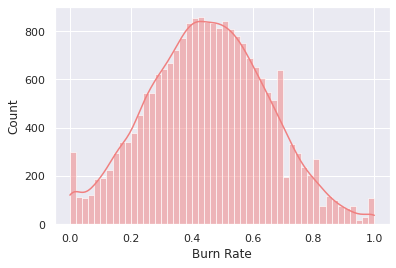

In [63]:
sns.histplot(data=train, x="Burn Rate", kde=True, color="lightcoral")

Распределение фичей

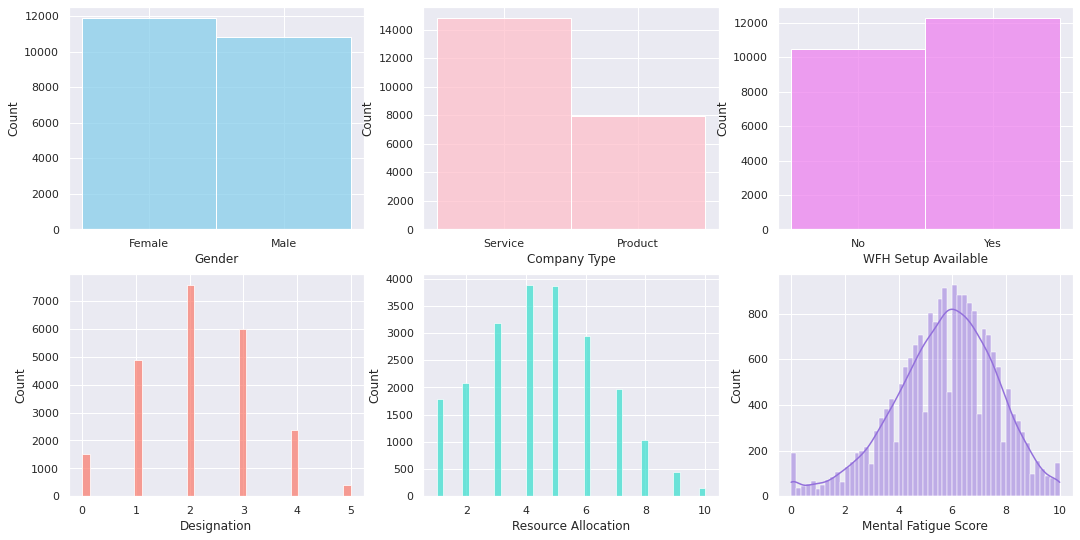

In [64]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(18, 9))

sns.histplot(data=train, x="Gender", color="skyblue", ax=axs[0, 0])
sns.histplot(data=train, x="Company Type", color="pink", ax=axs[0, 1])
sns.histplot(data=train, x="WFH Setup Available", color="violet", ax=axs[0, 2])
sns.histplot(data=train, x="Designation", color="salmon", ax=axs[1, 0])
sns.histplot(data=train, x="Resource Allocation", color="turquoise", ax=axs[1, 1])
sns.histplot(data=train, x="Mental Fatigue Score", kde=True, color="mediumpurple", ax=axs[1, 2])

plt.show()

Зависимости между численными фичами (по гендеру)

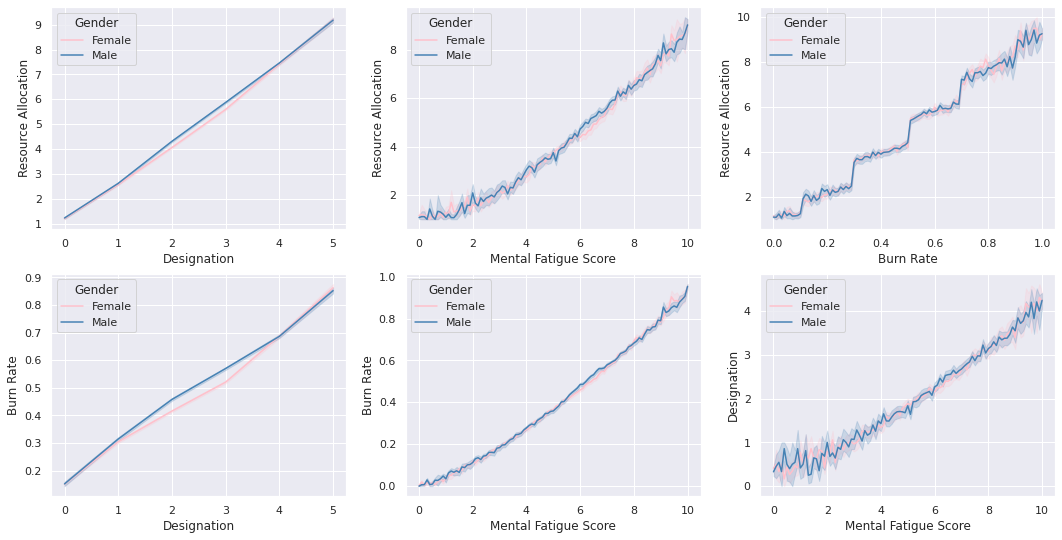

In [65]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(18, 9))

sns.lineplot(data=train, x="Designation", y="Resource Allocation", hue = 'Gender', palette=dict(Female='pink', Male='steelblue'), ax=axs[0, 0])
sns.lineplot(data=train, x="Mental Fatigue Score", y="Resource Allocation", hue = 'Gender', palette=dict(Female='pink', Male='steelblue'), ax=axs[0, 1])
sns.lineplot(data=train, x="Burn Rate", y="Resource Allocation", hue = 'Gender', palette=dict(Female='pink', Male='steelblue'), ax=axs[0, 2])
sns.lineplot(data=train, x="Designation", y="Burn Rate", hue = 'Gender', palette=dict(Female='pink', Male='steelblue'), ax=axs[1, 0])
sns.lineplot(data=train, x="Mental Fatigue Score", y="Burn Rate", hue = 'Gender', palette=dict(Female='pink', Male='steelblue'), ax=axs[1, 1])
sns.lineplot(data=train, x="Mental Fatigue Score", y="Designation", hue = 'Gender', palette=dict(Female='pink', Male='steelblue'), ax=axs[1, 2])

plt.show()

## Baseline

Задача: спрогнозировать уровень выгорания сотрудников на основе предоставленных фичей. С помощью такой модели можно помочь компании проанализировать состояние сотрудников и принимать соответствующие меры для поддержания их здоровья и повышения производительности.

1. Minimum data preparation:
- na values
- encoding (категориальные фичи и string)
2. Linear Regression

In [66]:
train.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

Убираем строчки с пустым таргетом - они не пригодятся. Остальные пустые строки заменяем медианным значением по колонкам.

In [67]:
missing_target_rows = train.loc[train['Burn Rate'].isna(), :].index
train = train.drop(missing_target_rows, axis=0).reset_index(drop=True)

In [68]:
for column in ['Resource Allocation', 'Mental Fatigue Score']:
        train[column] = train[column].fillna(train[column].mean())

**Какой способ энкодинга выбрать?**

Были проверены one-hot encoding и label encoding, модель не установила разной корреляции между фичами, выбор пал на label encoding.

In [69]:
le_train = train.copy()
for label in ['Gender', 'WFH Setup Available', 'Company Type']:
  le_train[label] = LabelEncoder().fit_transform(le_train[label])

le_train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,0,1,0,2.0,3.000000,3.8,0.16
1,fffe3700360033003500,2008-11-30,1,1,1,1.0,2.000000,5.0,0.36
2,fffe31003300320037003900,2008-03-10,0,0,1,2.0,4.483831,5.8,0.49
3,fffe32003400380032003900,2008-11-03,1,1,1,1.0,1.000000,2.6,0.20
4,fffe31003900340031003600,2008-07-24,0,1,0,3.0,7.000000,6.9,0.52


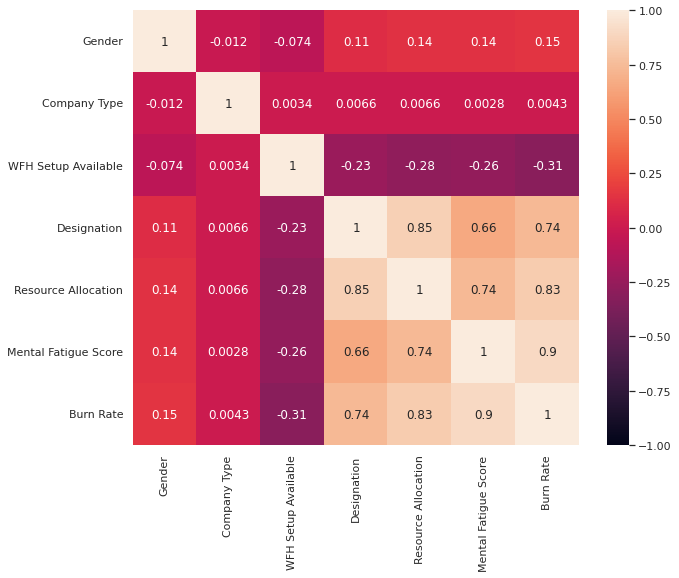

In [70]:
plt.figure(figsize=(10, 8))
sns.heatmap(le_train.corr(), vmin=-1, vmax=1, annot=True)

In [71]:
categorical_columns = ['Gender', 'Company Type', 'WFH Setup Available']
ohe_train = pd.get_dummies(train, columns = categorical_columns)

ohe_train.head()

,Employee ID,Date of Joining,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Gender_Female,Gender_Male,Company Type_Product,Company Type_Service,WFH Setup Available_No,WFH Setup Available_Yes
0,fffe32003000360033003200,2008-09-30,2.0,3.000000,3.8,0.16,1,0,0,1,1,0
1,fffe3700360033003500,2008-11-30,1.0,2.000000,5.0,0.36,0,1,0,1,0,1
2,fffe31003300320037003900,2008-03-10,2.0,4.483831,5.8,0.49,1,0,1,0,0,1
3,fffe32003400380032003900,2008-11-03,1.0,1.000000,2.6,0.20,0,1,0,1,0,1
4,fffe31003900340031003600,2008-07-24,3.0,7.000000,6.9,0.52,1,0,0,1,1,0


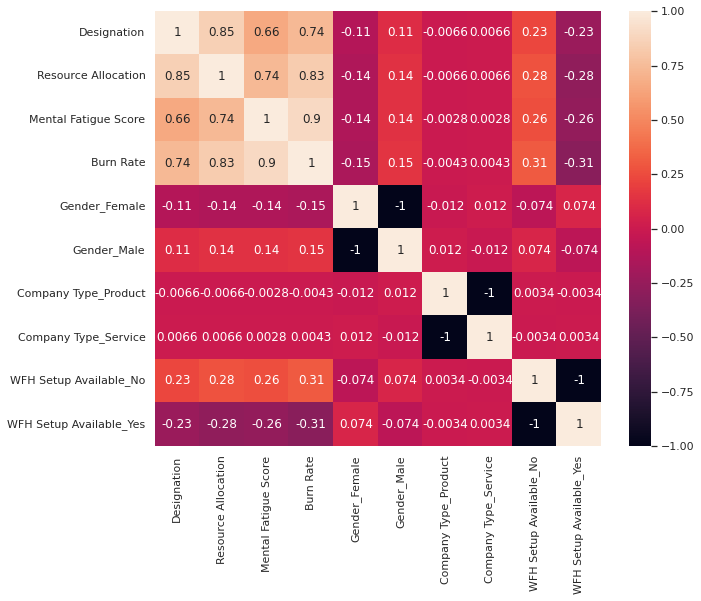

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(ohe_train.corr(), vmin=-1, vmax=1, annot=True)

Emplyee ID выкинем далее, осталось только преобразовать дату из str в int:

In [73]:
le_train["Date of Joining"] = [int(str(val).replace('-','')) for val in le_train["Date of Joining"].values]

In [74]:
le_train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,20080930,0,1,0,2.0,3.000000,3.8,0.16
1,fffe3700360033003500,20081130,1,1,1,1.0,2.000000,5.0,0.36
2,fffe31003300320037003900,20080310,0,0,1,2.0,4.483831,5.8,0.49
3,fffe32003400380032003900,20081103,1,1,1,1.0,1.000000,2.6,0.20
4,fffe31003900340031003600,20080724,0,1,0,3.0,7.000000,6.9,0.52


20% процентов тренировочной выборки отложим для валидации. Emloyee ID выбрасываем.

In [75]:
X = le_train.iloc[:, 1:-1]
y = le_train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                         test_size=0.2, 
                                         shuffle=True, 
                                         random_state=RANDOM_SEED)

print("Shape of train set:\nX_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShape of test set:\nX_test:", X_test.shape)
print("y_test:", y_test.shape)

Shape of train set:
X_train: (17300, 7)
y_train: (17300,)

Shape of test set:
X_test: (4326, 7)
y_test: (4326,)


In [76]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_test_lr_pred = lr.predict(X_test)

Посмотрим на метрики: для оценки эффективности регрессии используются **Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE)**. **Коэффициент детерминации** является статистической мерой согласия, с помощью которой можно определить, насколько уравнение регрессии соответствует реальным данным. Если он равен 0, это означает, что связь между переменными регрессионной модели отсутствует и вместо нее для оценки значения выходной переменной можно использовать простое среднее ее наблюдаемых значений. Если коэффициент равен 1, это соответствует идеальной модели, когда все точки наблюдений лежат точно на линии регрессии, т.е. сумма квадратов их отклонений равна 0.

In [77]:
def show_errors(y_validations, y_predictions):
    mae_test = mae(y_validations, y_predictions)
    mse_test = mse(y_validations, y_predictions)
    rmse_test = sqrt(mse(y_validations, y_predictions))
    r2_test = r2_score(y_validations, y_predictions)

    print("\n---------Error Statistics for Test---------")
    print(f"Mean Absolute Error (MAE)             : {mae_test:.4f}")
    print(f"Mean Square Error (MSE)               : {mse_test:.4f}")
    print(f"Root Mean Square Error (RMSE)         : {rmse_test:.4f}")
    print(f"Coefficient of Determination (R2)     : {r2_test:.4f}\n")

In [78]:
show_errors(y_test, y_test_lr_pred)


---------Error Statistics for Test---------
Mean Absolute Error (MAE)             : 0.0535
Mean Square Error (MSE)               : 0.0050
Root Mean Square Error (RMSE)         : 0.0707
Coefficient of Determination (R2)     : 0.8686



In [79]:
def show_comparison(y_validations, y_predictions):
    plt.figure(figsize=(12,6))
    plt.scatter(y_validations, 
                y_predictions, 
                color="k", alpha=0.6, s=10, label="Predicted")
    plt.plot(y_validations, y_validations, "r--", label="True")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs. Predicted Values")
    plt.legend(fontsize="large", loc="best")
    plt.show()

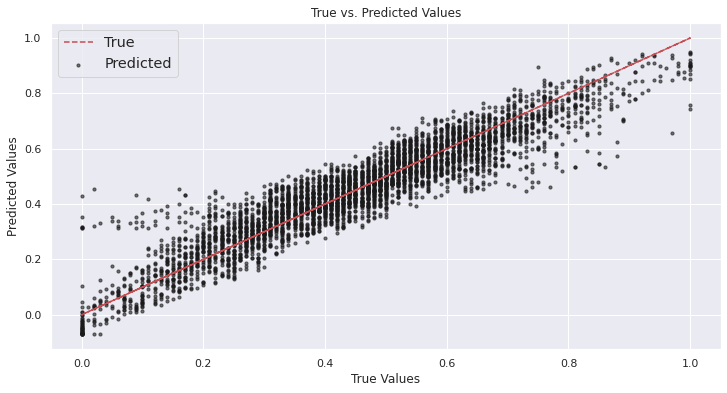

In [80]:
show_comparison(y_test, y_test_lr_pred)

## Инжениринг фичей

### Date of Joining

Все сотрудники в датасете устроились на работу в 2008 году. Таким образом, опуская год и преобразуя месяцы и дни в срок пребывания в должности, гипотетически можно улучшить качество модели.

In [81]:
le_train = train.copy()
for label in ['Gender', 'WFH Setup Available', 'Company Type']:
  le_train[label] = LabelEncoder().fit_transform(le_train[label])

le_train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,0,1,0,2.0,3.000000,3.8,0.16
1,fffe3700360033003500,2008-11-30,1,1,1,1.0,2.000000,5.0,0.36
2,fffe31003300320037003900,2008-03-10,0,0,1,2.0,4.483831,5.8,0.49
3,fffe32003400380032003900,2008-11-03,1,1,1,1.0,1.000000,2.6,0.20
4,fffe31003900340031003600,2008-07-24,0,1,0,3.0,7.000000,6.9,0.52


In [82]:
le_train["Date of Joining"] = pd.to_datetime(le_train["Date of Joining"])
le_train.dtypes

Employee ID                     object
Date of Joining         datetime64[ns]
Gender                           int64
Company Type                     int64
WFH Setup Available              int64
Designation                    float64
Resource Allocation            float64
Mental Fatigue Score           float64
Burn Rate                      float64
dtype: object

In [83]:
dt_today = dt.date.today()
le_train["today"] = dt_today
# сегодняшняя дата передается в формате str, необходим datetime64[ns] для подсчета длительности работы
le_train["today"] = pd.to_datetime(le_train["today"])
le_train['tenure'] = le_train['today'] - le_train["Date of Joining"]
le_train['tenure'] = le_train['tenure'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


Убираем лишние колонки

In [84]:
le_train = le_train.drop(["Employee ID", "Date of Joining", "today"], axis=1)

In [85]:
le_train.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,tenure
0,0,1,0,2.0,3.000000,3.8,0.16,432950400000000000
1,1,1,1,1.0,2.000000,5.0,0.36,427680000000000000
2,0,0,1,2.0,4.483831,5.8,0.49,450576000000000000
3,1,1,1,1.0,1.000000,2.6,0.20,430012800000000000
4,0,1,0,3.0,7.000000,6.9,0.52,438825600000000000


In [86]:
X = le_train.drop('Burn Rate', axis=1)
y = le_train['Burn Rate']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                         test_size=0.2, 
                                         shuffle=True, 
                                         random_state=RANDOM_SEED)

### Нормализация

Попробуем **нормализовать данные**. Будучи разными по физическому смыслу, данные сильно различаются между собой по абсолютным величинам. Дисбаланс между значениями признаков может вызвать неустойчивость работы модели, ухудшить результаты обучения и замедлить процесс моделирования. В частности, параметрические методы машинного обучения (нейронные сети, растущие деревья) обычно требуют симметричного и унимодального распределения данных. Популярный метод ближайших соседей, часто используемый в задачах классификации и иногда в регрессионном анализе, также чувствителен к диапазону изменений входных переменных.

In [88]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [89]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test_lr_pred = lr.predict(X_test)

In [90]:
show_errors(y_test, y_test_lr_pred)


---------Error Statistics for Test---------
Mean Absolute Error (MAE)             : 0.0535
Mean Square Error (MSE)               : 0.0050
Root Mean Square Error (RMSE)         : 0.0707
Coefficient of Determination (R2)     : 0.8686



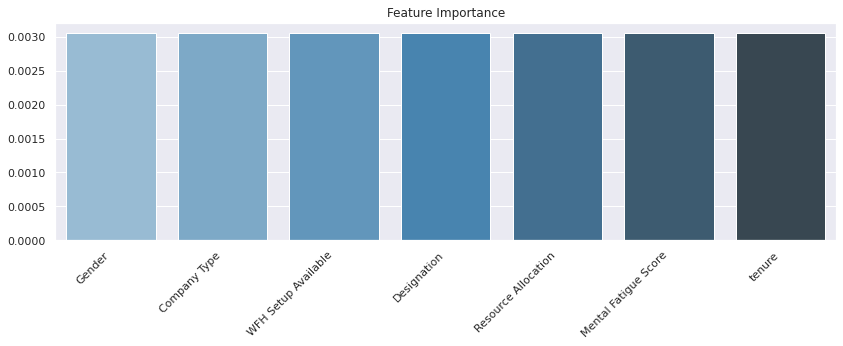

In [91]:
# визуализация важности признаков
LR_feature_importance = pd.Series(abs(lr.coef_[0]), index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(14, 4))
plt.title('Feature Importance')
sns.barplot(x = LR_feature_importance.index, y = LR_feature_importance, palette="Blues_d")
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

### Date of Joining (2)

In [92]:
le_train = train.copy()
for label in ['Gender', 'WFH Setup Available', 'Company Type']:
  le_train[label] = LabelEncoder().fit_transform(le_train[label])

le_train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,0,1,0,2.0,3.000000,3.8,0.16
1,fffe3700360033003500,2008-11-30,1,1,1,1.0,2.000000,5.0,0.36
2,fffe31003300320037003900,2008-03-10,0,0,1,2.0,4.483831,5.8,0.49
3,fffe32003400380032003900,2008-11-03,1,1,1,1.0,1.000000,2.6,0.20
4,fffe31003900340031003600,2008-07-24,0,1,0,3.0,7.000000,6.9,0.52


In [93]:
le_train['Date of Joining'] = pd.to_datetime(le_train['Date of Joining'])
le_train['Join Month'] = le_train['Date of Joining'].apply(lambda x: x.month)
le_train['Join Day'] = le_train['Date of Joining'].apply(lambda x: x.day)
le_train = le_train.drop(['Date of Joining', 'Employee ID'], axis=1)

In [94]:
le_train.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Join Month,Join Day
0,0,1,0,2.0,3.000000,3.8,0.16,9,30
1,1,1,1,1.0,2.000000,5.0,0.36,11,30
2,0,0,1,2.0,4.483831,5.8,0.49,3,10
3,1,1,1,1.0,1.000000,2.6,0.20,11,3
4,0,1,0,3.0,7.000000,6.9,0.52,7,24


In [95]:
X = le_train.drop('Burn Rate', axis=1)
y = le_train['Burn Rate']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                         test_size=0.2, 
                                         shuffle=True, 
                                         random_state=RANDOM_SEED)

In [97]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [98]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test_lr_pred = lr.predict(X_test)

In [99]:
show_errors(y_test, y_test_lr_pred)


---------Error Statistics for Test---------
Mean Absolute Error (MAE)             : 0.0535
Mean Square Error (MSE)               : 0.0050
Root Mean Square Error (RMSE)         : 0.0707
Coefficient of Determination (R2)     : 0.8687



## Модели

Для поиска оптимальных параметров попробуем 2 метода: поиск по сетке и рандомизированный поиск

### KNeighborsRegressor

In [100]:
# функция для тренировки с GridSearchCV
def train_model(estimator, parameters, cv=10, verbose=1, X_data=X_train):
    gridCV = GridSearchCV(estimator=estimator, 
                          param_grid=parameters, 
                          n_jobs=-1, 
                          cv=cv, 
                          verbose=verbose)
    gridCV.fit(X_data, y_train)

    print("\nBest training parameters:", gridCV.best_params_)
    print("Best training score: {:.4f}".format(gridCV.best_score_))
    show_errors(y_test, gridCV.predict(X_test))
    
    return gridCV

In [101]:
knn_model = KNeighborsRegressor(n_jobs=-1)
knn_params = {"n_neighbors":range(10, 20), 
              "weights":("uniform", "distance"), 
              "metric":("euclidean", "minkowski", "manhattan")
              }

knn_gridCV = train_model(knn_model, knn_params)

Fitting 10 folds for each of 60 candidates, totalling 600 fits

Best training parameters: {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}
Best training score: 0.8640

---------Error Statistics for Test---------
Mean Absolute Error (MAE)             : 0.0554
Mean Square Error (MSE)               : 0.0052
Root Mean Square Error (RMSE)         : 0.0722
Coefficient of Determination (R2)     : 0.8631



### DecisionTreeRegressor

In [102]:
tree_model = DecisionTreeRegressor(random_state=19)
tree_params = {"max_depth":range(8,10), 
               "min_samples_split":range(2,5), 
               "splitter":("best", "random"), 
               "min_samples_leaf":range(5,15)
              }

tree_gridCV = train_model(tree_model, tree_params)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits

Best training parameters: {'max_depth': 9, 'min_samples_leaf': 11, 'min_samples_split': 2, 'splitter': 'best'}
Best training score: 0.9005

---------Error Statistics for Test---------
Mean Absolute Error (MAE)             : 0.0480
Mean Square Error (MSE)               : 0.0038
Root Mean Square Error (RMSE)         : 0.0614
Coefficient of Determination (R2)     : 0.9011



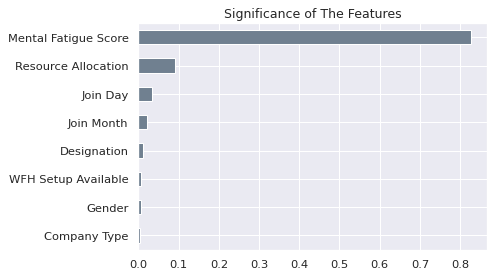

In [103]:
tree_model.fit(X_test, y_test)

sp = dict(zip(X_train.columns, tree_model.feature_importances_))
# sorting w.r.t their significance values:
sp = {k: v for k, v in sorted(sp.items(), key=lambda i: i[1], reverse=True)}

significant_names = list(sp.keys())
significant_values = list(sp.values())

significance = pd.Series(data=significant_values,
                         index=significant_names).sort_values()
plt.figure(dpi=75)
significance.plot(kind="barh", color="slategrey")
plt.title("Significance of The Features")
plt.show()
del sp, significant_names, significant_values, significance

### XGBoost with tuning

В основе XGBoost лежит алгоритм градиентного бустинга деревьев решений.

Искать оптимальные параметры для обучения модели будем методом рандомизированного поиска среди следующих параметров:
- **n_estimators** – число итераций в бустинге. Чем больше, тем лучше качество, однако слишком большой увеличение данного параметра может привести к ухудшению производительности и переобучению.
- **max_depth** – максимальная глубина дерева. Используется для того, чтобы исключить возможность переобучения.
- **learning_rate** – скорость обучения

XGBoost поддерживает k-Fold cross validation с использованием метода cv().

In [104]:
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror', seed=42)
params = {  
    "n_estimators": range(1, 500, 50),
    "max_depth": range(1, 20, 2),
    "learning_rate": st.uniform(0.1, 0.9)     
} 

rs_cv = RandomizedSearchCV(xgb_reg, params, n_jobs=-1, n_iter=15, cv=10, verbose=3, random_state=RANDOM_SEED)  
rs_cv.fit(X_train, y_train) 
best_params = rs_cv.best_params_

print("\nBest training parameters:", rs_cv.best_params_)
print("Best training score: {:.4f}".format(rs_cv.best_score_))

Fitting 10 folds for each of 15 candidates, totalling 150 fits

Best training parameters: {'learning_rate': 0.1185260448662222, 'max_depth': 3, 'n_estimators': 351}
Best training score: 0.9088


In [105]:
xgb_model = xgb.XGBRegressor(
    n_estimators=best_params["n_estimators"] , 
    max_depth=best_params["max_depth"] , 
    learning_rate=best_params["learning_rate"])

xgb_model.fit(X_train, y_train)

xgb_y_pred = xgb_model.predict(X_test)
show_errors(y_test, xgb_y_pred)

[17:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

---------Error Statistics for Test---------
Mean Absolute Error (MAE)             : 0.0469
Mean Square Error (MSE)               : 0.0035
Root Mean Square Error (RMSE)         : 0.0595
Coefficient of Determination (R2)     : 0.9072



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


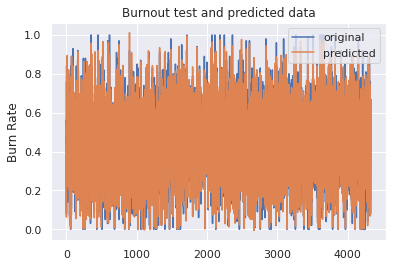

In [106]:
x_ax = range(len(y_test))
sns.lineplot(x_ax, y_test, label="original")
sns.lineplot(x_ax, xgb_y_pred, label="predicted")

plt.title("Burnout test and predicted data")
plt.legend(loc='upper right')
plt.show()

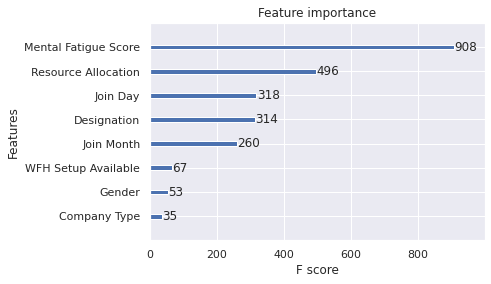

<Figure size 1152x864 with 0 Axes>

In [109]:
xgb.plot_importance(xgb_model)
plt.figure(figsize = (16, 12))
plt.show()